# CMPT 310: Project

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("no issue")

no issue


In [40]:
df = pd.read_csv('Data/edited data/merged_data.csv')
df_merged = df.astype(float)
print(df_merged.iloc[0])

YEAR                                         1990.000000
GDMPBC                                      41964.000000
Total, all education levels                     7.400000
0 to 8  years 8                                10.500000
Some high school 9                             12.900000
High school graduate 10                         6.700000
Some postsecondary 11                           8.800000
Postsecondary certificate or diploma 12         6.200000
University degree 13                            4.300000
Bachelor's degree                               4.600000
Above bachelor's degree                         3.900000
All Items Index                                78.400000
Annual Percent Change                           5.400000
QUARTER                                         1.000000
MEDIAN HOUSING PRICE                       147500.000000
MEDIAN AFTER TAX FAMILY INCOME              37138.510090
PRIME INTEREST RATE                            13.846154
QUARTERLY PAYMENT              

### Linear Regression & Gradient Boosting

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split train/test
df_train = df_merged[df_merged['YEAR'] <= 2018]
df_test = df_merged[df_merged['YEAR'] > 2018]

trend_features = ['YEAR', 'QUARTER', 'GDMPBC', 'All Items Index', 'Annual Percent Change', 'MEDIAN AFTER TAX FAMILY INCOME','PRIME INTEREST RATE','QUARTERLY PAYMENT','PAYMENT TO INCOME PERCENT','NUMBER OF RESALES']
tree_features = ['Total, all education levels', 'High school graduate 10', 'Some high school 9', 'Some postsecondary 11', 'Postsecondary certificate or diploma 12', "Bachelor's degree", '0 to 8  years 8', 'University degree 13', "Above bachelor's degree", 'PRIME INTEREST RATE', 'MEDIAN AFTER TAX FAMILY INCOME']

# Step 1: Linear Regression for Trend
print("Trend features:", trend_features)
x_train = df_train[trend_features]
x_test = df_test[trend_features]
LR_model = LinearRegression()
LR_model.fit(x_train, df_train['MEDIAN HOUSING PRICE'])
trend_pred_train = LR_model.predict(x_train)
trend_pred_test = LR_model.predict(x_test)

# Evaluate linear trend alone
mse = mean_squared_error(df_test['MEDIAN HOUSING PRICE'], trend_pred_test)
r2 = r2_score(df_test['MEDIAN HOUSING PRICE'], trend_pred_test)
print(f'[Linear Trend] Mean Squared Error: {mse:.2f}, Sqrt MSE: {np.sqrt(mse):.2f}')
print(f'[Linear Trend] R^2 Score: {r2:.2f}')

# Step 2: Residual Boosting Technique (Decision Tree)
residuals = df_train['MEDIAN HOUSING PRICE'] - trend_pred_train
print("Tree features:", tree_features)

tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(df_train[tree_features], residuals)
residual_pred = tree_model.predict(df_test[tree_features])

# Final prediction by combining trend and residuals
final_pred = trend_pred_test + residual_pred

# Evaluate combined model
mse = mean_squared_error(df_test['MEDIAN HOUSING PRICE'], final_pred)
r2 = r2_score(df_test['MEDIAN HOUSING PRICE'], final_pred)
print(f'[Trend + Tree] Mean Squared Error: {mse:.2f}, Sqrt MSE: {np.sqrt(mse):.2f}')
print(f'[Trend + Tree] R^2 Score: {r2:.2f}')

Trend features: ['YEAR', 'QUARTER', 'GDMPBC', 'All Items Index', 'Annual Percent Change', 'MEDIAN AFTER TAX FAMILY INCOME', 'PRIME INTEREST RATE', 'QUARTERLY PAYMENT', 'PAYMENT TO INCOME PERCENT', 'NUMBER OF RESALES']
[Linear Trend] Mean Squared Error: 1291777058.82, Sqrt MSE: 35941.30
[Linear Trend] R^2 Score: 0.80
Tree features: ['Total, all education levels', 'High school graduate 10', 'Some high school 9', 'Some postsecondary 11', 'Postsecondary certificate or diploma 12', "Bachelor's degree", '0 to 8  years 8', 'University degree 13', "Above bachelor's degree", 'PRIME INTEREST RATE', 'MEDIAN AFTER TAX FAMILY INCOME']
[Trend + Tree] Mean Squared Error: 846401260.08, Sqrt MSE: 29092.98
[Trend + Tree] R^2 Score: 0.87


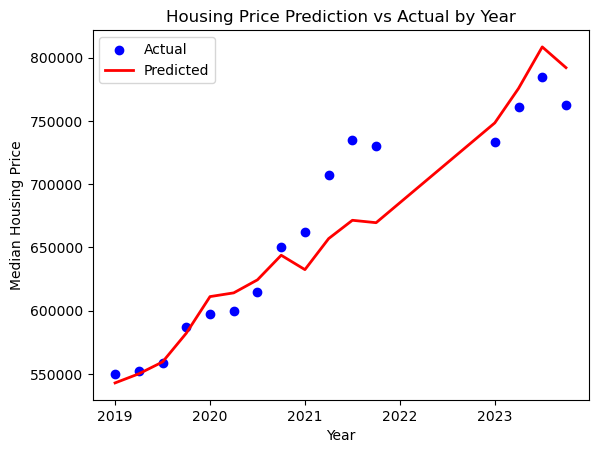

In [42]:
# merge year and quarter into a single feature for plot
df_test.loc[:, 'YEAR'] = df_test['YEAR'] + (df_test['QUARTER'] - 1) * 0.25
df_test = df_test.drop(columns=['QUARTER'])

# plot for actual values & predicted values
plt.scatter(df_test['YEAR'], df_test['MEDIAN HOUSING PRICE'], color='blue', label='Actual')
plt.plot(df_test['YEAR'], final_pred, color='red', linewidth=2, label='Predicted')

plt.xlabel('Year')
plt.ylabel('Median Housing Price')
plt.title('Housing Price Prediction vs Actual by Year')
plt.legend()
plt.show()

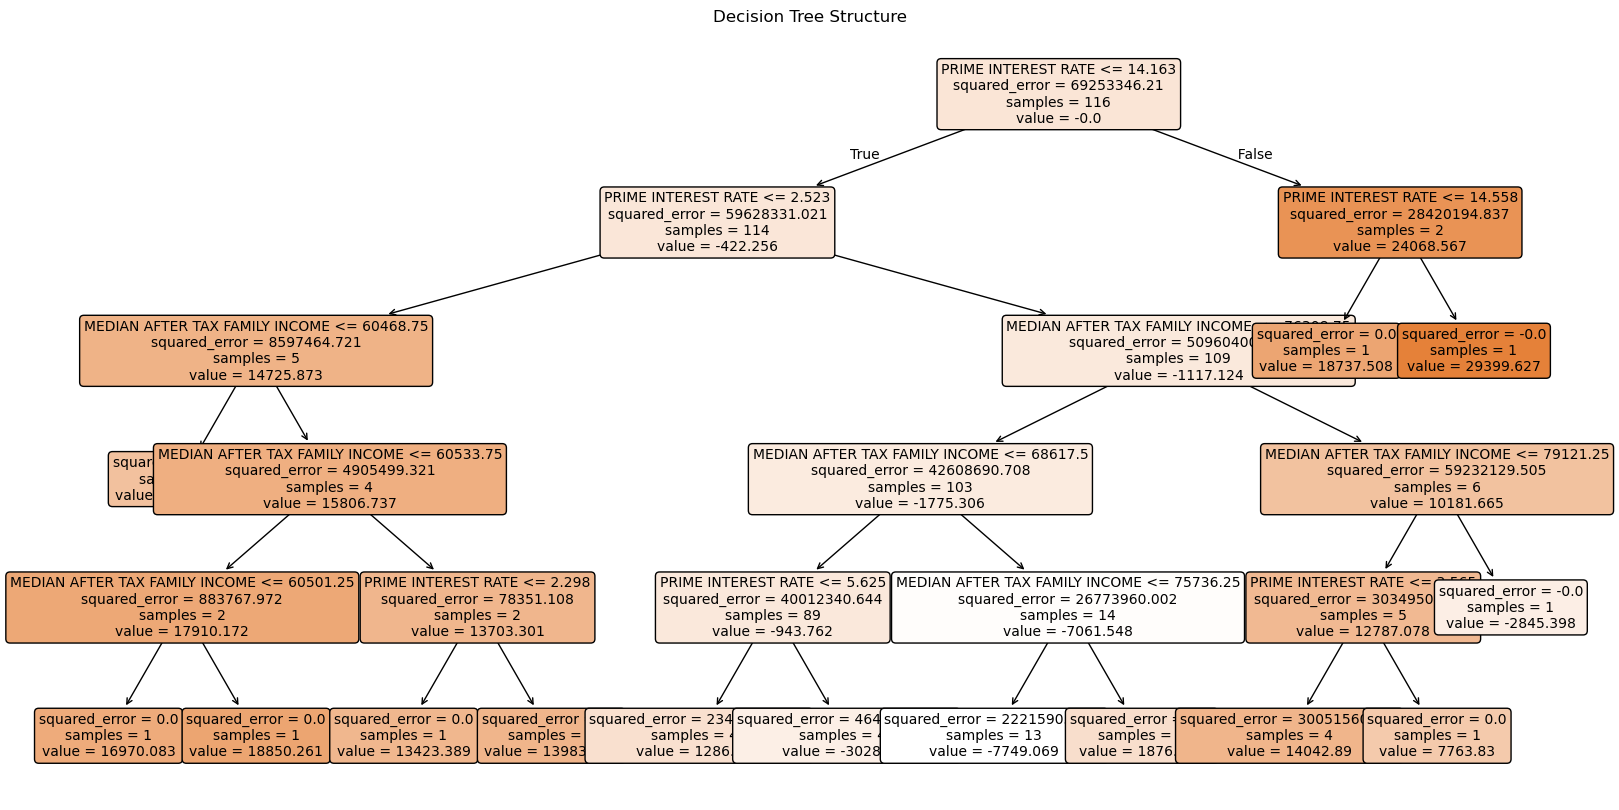

In [44]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    tree_model,
    feature_names=df_train[tree_features].columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure")
plt.show()